# Análisis del Dataset

Como se dijo, originalmente la idea era analizar aquellos sonidos cuya duración era menor a 5 segundos, ya que a priori se pensaba que de los mismos se podía extraer mejor información, ya que su contenido no varia tanto en el tiempo, pero se descartó, ya que se encontró que el dataset elegido contaba con muy pocas instancias de este tipo.

### Se levanta dataset del archivo .csv previamente generado

In [9]:
import pandas as pd

data = pd.read_csv('snd-dataset.csv')

# Descripción de los features

**duration**: Duration of audio file in seconds.

**loudness**: The integrated (overall) loudness (LUFS) measured using the EBU R128 standard.

**log_attack_time**: The log (base 10) of the attack time of a signal envelope. The attack time is defined as the time duration from when the sound becomes perceptually audible to when it reaches its maximum intensity.

**tempo**: BPM value estimated by beat tracking algorithm.

**temporal_centroid**: Temporal centroid (sec.) of the audio signal. It is the point in time in a signal that is a temporal balancing point of the sound event energy.

**(pitch?) note_frequency**: Frequency corresponding to the estimated note.

**Key**: Tonality value estimated by key detection algorithm.


**Referencia**: https://github.com/AudioCommons/ac-audio-extractor


## Se filtra y solo se dejan las columnas de interés para agrupar

In [10]:
# Descarto columnas que no se van a usar por ahora
# Tip: axis number (0 for rows and 1 for columns)
data = data.drop("Tempo.confidence", axis=1);
data = data.drop("Pitch.confidence", axis=1);
data = data.drop("Key.confidence", axis=1);

#data = data.drop("Loop", axis=1);
#data = data.drop("Key", axis=1);
data.head()

,Duration,Loudness,LogAttackTime,Tempo,TemporalCentroid,Pitch,Key,Loop
0,24.688000,-9.428771,0.643956,122,0.554729,150.475891,A minor,False
1,9.743673,-15.724195,-1.538928,99,0.515523,172.650284,A# major,True
2,2.965000,-41.118546,-0.108449,98,0.436209,1856.814087,C# minor,False
3,212.834106,-13.990514,1.079394,94,0.471911,233.854294,B major,False
4,1.985306,-12.687588,-0.707071,125,0.517171,269.756226,C major,False


## Gráficos y agrupación por k-means

In [11]:
from sklearn import datasets
from sklearn.cluster import KMeans

import sklearn.metrics as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [13]:
data.index
AMOUNT = data.shape[0]

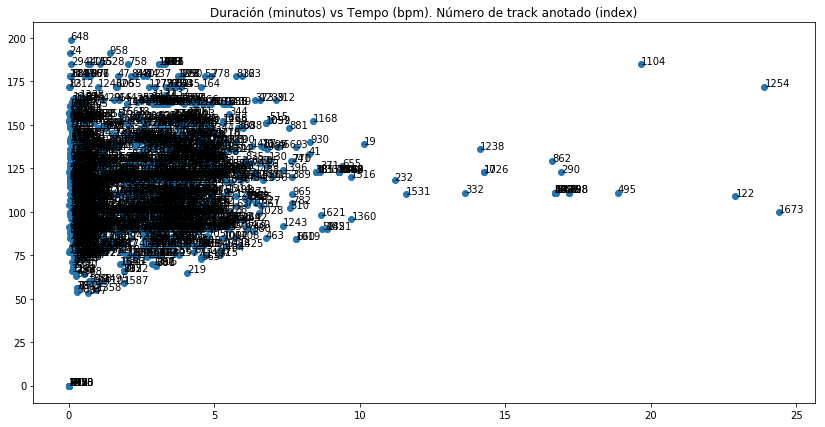

In [14]:
# Plot de duración vs tempo, anotando el número de track en cada punto/marker...
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(data.Duration/60.,data.Tempo, ls="", marker="o")
for xi, yi, pidi in zip(data.Duration/60.,data.Tempo,data.index):
    ax.annotate(str(pidi), xy=(xi,yi))

plt.title('Duración (minutos) vs Tempo (bpm). Número de track anotado (index)')
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


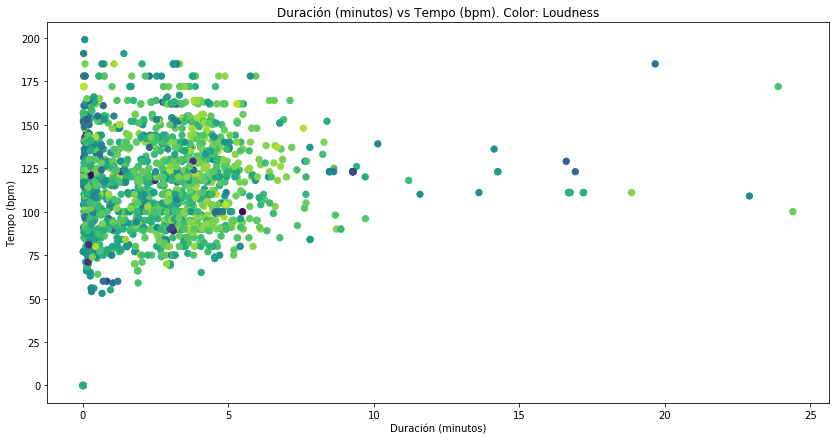

In [15]:
colormap_original = cm.viridis_r(np.linspace(0,1,abs(np.max(abs(data.Loudness)*AMOUNT))+1))

plt.figure(figsize=(14,7))
plt.scatter(data.Duration/60., data.Tempo, c=colormap_original[(abs(data.Loudness)*AMOUNT).astype(int) ], s=40)
plt.title('Duración (minutos) vs Tempo (bpm). Color: Loudness') # más oscuro es más alto

plt.xlabel('Duración (minutos)')
plt.ylabel('Tempo (bpm)')
plt.show()

In [16]:
# Pasar categorias columna 'key' a numérica

key_to_number_list = ['A minor', 'A major', 'A# minor', 'A# major', 'B minor', 'B major', 'C minor', 'C major', 'C# minor', 'C# major', 'D minor', 'D major', 'D# minor', 'D# major','E minor', 'E major', 'F minor', 'F major', 'F# minor', 'F# major', 'G minor', 'G major','G# minor', 'G# major']

def keyToNumber(x_value):
    return [i for i,x in enumerate(key_to_number_list) if x == x_value][0]

# Mapeo de las tonalidades 'en texto' a categorias numéricas
data['Key'] = data['Key'].map(keyToNumber)

In [17]:
# diferentes cantidades de clusters
#num_clusters = 3
num_clusters = 8


model = KMeans(n_clusters=num_clusters) 
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

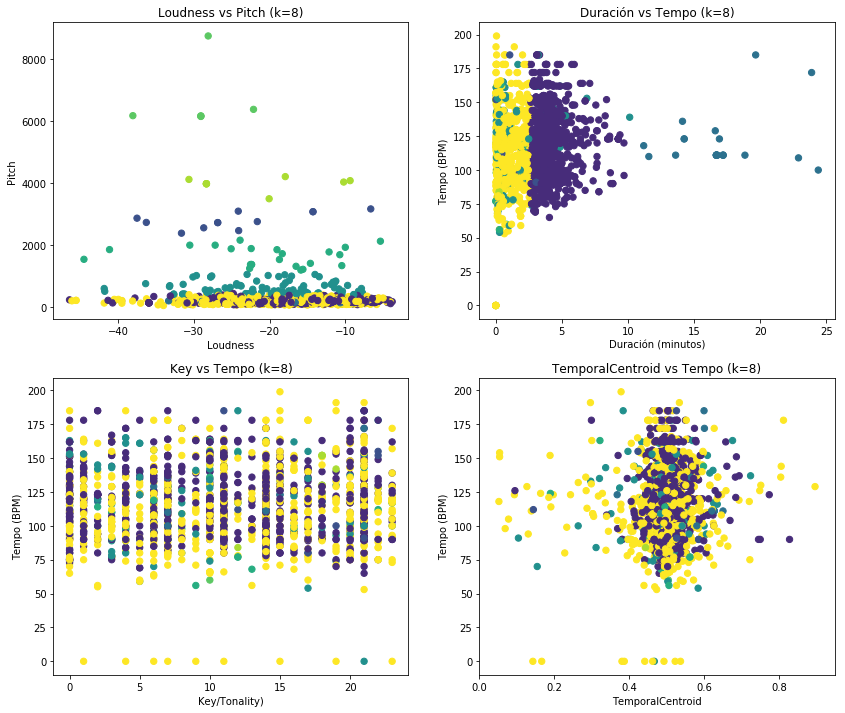

In [18]:
# Comparaciones para comprender el dataset

plt.figure(figsize=(14,12))

colormap_original = cm.viridis_r(np.linspace(0,1,num_clusters+1))

# Loudness vs Pitch
plt.subplot(2, 2, 1)
plt.scatter(data.Loudness, data.Pitch, c=colormap_original[model.labels_], s=40)
plt.title('Loudness vs Pitch (k=%s)'%num_clusters)
plt.xlabel('Loudness')
plt.ylabel('Pitch')

# Duración vs Tempo
plt.subplot(2, 2, 2)
plt.scatter(data.Duration/60., data.Tempo, c=colormap_original[model.labels_], s=40)
plt.title('Duración vs Tempo (k=%s)'%num_clusters)
plt.xlabel('Duración (minutos)')
plt.ylabel('Tempo (BPM)')

# Key vs Tempo
plt.subplot(2, 2, 3)
plt.scatter(data.Key, data.Tempo, c=colormap_original[model.labels_], s=40)
plt.title('Key vs Tempo (k=%s)'%num_clusters)
plt.xlabel('Key/Tonality)')
plt.ylabel('Tempo (BPM)')

# TemporalCentroid
plt.subplot(2, 2, 4)
plt.scatter(data.TemporalCentroid, data.Tempo, c=colormap_original[model.labels_], s=40)
plt.title('TemporalCentroid vs Tempo (k=%s)'%num_clusters)
plt.xlabel('TemporalCentroid')
plt.ylabel('Tempo (BPM)')

plt.show()

Text(0, 0.5, 'Duración (minutos)')

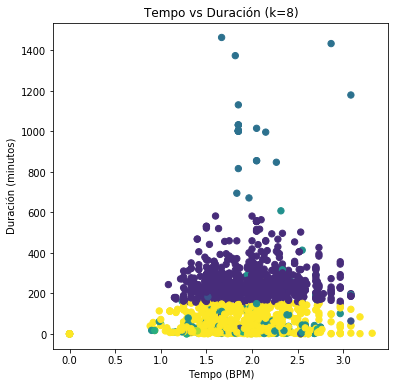

In [19]:
# Tempo vs Duración

plt.figure(figsize=(6,6))
plt.scatter(data.Tempo/60., data.Duration, c=colormap_original[model.labels_], s=40)
plt.title('Tempo vs Duración (k=%s)'%num_clusters)

plt.xlabel('Tempo (BPM)')
plt.ylabel('Duración (minutos)')

### Posibles outliers
![](img/posibles-outliers.png)